In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vugrad.ops import Normalize
from vugrad.core import TensorNode, Op
from copy import deepcopy
from scipy.stats import ttest_ind

class Normalize1(Op):
    @staticmethod
    def forward(context, x):
        sumd = x.sum(axis=1, keepdims=True)
        context['x'], context['sumd'] = x, sumd
        return x / sumd

    @staticmethod
    def backward(context, go):
        x, sumd = context['x'], context['sumd']
        return (go / sumd) - (x/(sumd * sumd) * go.sum(axis=1, keepdims=True))

In [2]:
x = np.random.uniform(high=100, size=(4, 5))
dx = np.random.randn(4, 5)
context = dict()

In [3]:
Normalize.forward(context, x)
Normalize.backward(context, dx)

array([[ 0.00258445,  0.00450274, -0.00117835, -0.00419621,  0.00203085],
       [-0.01995392, -0.00216042, -0.0006074 , -0.01129472,  0.01299725],
       [-0.00252262,  0.00588863,  0.00270263, -0.00114675, -0.00381413],
       [-0.00215699, -0.00165253,  0.00287776,  0.00415856, -0.00070481]])

In [4]:
Normalize1.backward(context, dx)

array([[ 0.00208761,  0.00313648, -0.00156404, -0.00482493,  0.00116488],
       [-0.01157212,  0.00097811, -0.00513552, -0.00320044,  0.01892997],
       [-0.00321665,  0.0053649 ,  0.00272842, -0.00090332, -0.00397335],
       [-0.00247179, -0.00219097,  0.00238247,  0.00339232, -0.00111202]])

In [5]:
EPOCH = 4000

def GD(norm):
    b = TensorNode(np.asarray([[0], [-0.5], [0.3], [0.7], [-0.5]]))
    x = TensorNode(np.random.uniform(high=100, size=(4, 5)))

    values = list()
    for i in range(EPOCH):
        o = norm.do_forward(x)
        o = o.matmul(b)
        ot = TensorNode(deepcopy(o.value.T))
        o = ot.matmul(o)
        o.backward()
        x.value = x.value - 30 * x.grad
        o.zero_grad()
        values.append(o.value.squeeze())
    return values

def runs(norm, n=100):
    return pd.DataFrame([GD(norm) for _ in range(n)]).T

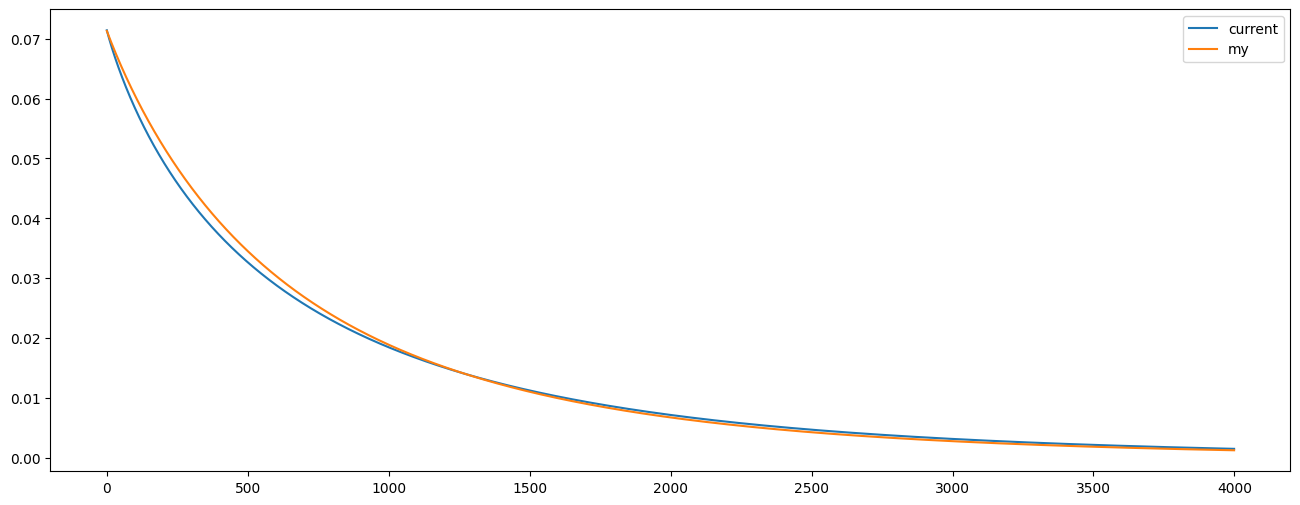

In [6]:
df1, df2 = runs(Normalize, n=500), runs(Normalize1, n=500)

plt.figure(figsize=(16, 6))
plt.plot(df1.mean(axis=1), label='current')
plt.plot(df2.mean(axis=1), label='my')
plt.legend()
plt.show()

In [7]:
df1.iloc[-1].mean()

0.0014699605356661345

In [8]:
df2.iloc[-1].mean()

0.0012270172495217617

In [9]:
ttest_ind(df1.iloc[-1].astype(np.float32), df2.iloc[-1].astype(np.float32))

Ttest_indResult(statistic=3.050924494759733, pvalue=0.002341665120129245)